In [1]:
%load_ext autoreload
%autoreload 2

[VesselSegmentationDataset] Initialized with 7 samples
[VesselSegmentationDataset] Target size: (1024, 1024)
[VesselSegmentationDataset] GCN enabled: True
[VesselSegmentationInference] Initialized
  Device: cuda
  Model loaded from: SavedModels/demo_model_sota.pth
  Target size: (1024, 1024)
  Global contrast normalization: True
Sample: 01_h
  Accuracy: 0.9432
  Precision: 0.7598
  Recall: 0.6469
  F1 Score: 0.6988
Sample: 02_dr
  Accuracy: 0.9298
  Precision: 0.4713
  Recall: 0.8126
  F1 Score: 0.5966
Sample: 02_g
  Accuracy: 0.9426
  Precision: 0.5860
  Recall: 0.7815
  F1 Score: 0.6698
Sample: 05_dr
  Accuracy: 0.9302
  Precision: 0.4659
  Recall: 0.8386
  F1 Score: 0.5990
Sample: 08_h
  Accuracy: 0.9440
  Precision: 0.6830
  Recall: 0.8251
  F1 Score: 0.7473
Sample: 09_g
  Accuracy: 0.9486
  Precision: 0.5958
  Recall: 0.6970
  F1 Score: 0.6424
Sample: 13_dr
  Accuracy: 0.9533
  Precision: 0.6488
  Recall: 0.6898
  F1 Score: 0.6687

Average Metrics Across All Samples:
  Accuracy: 0

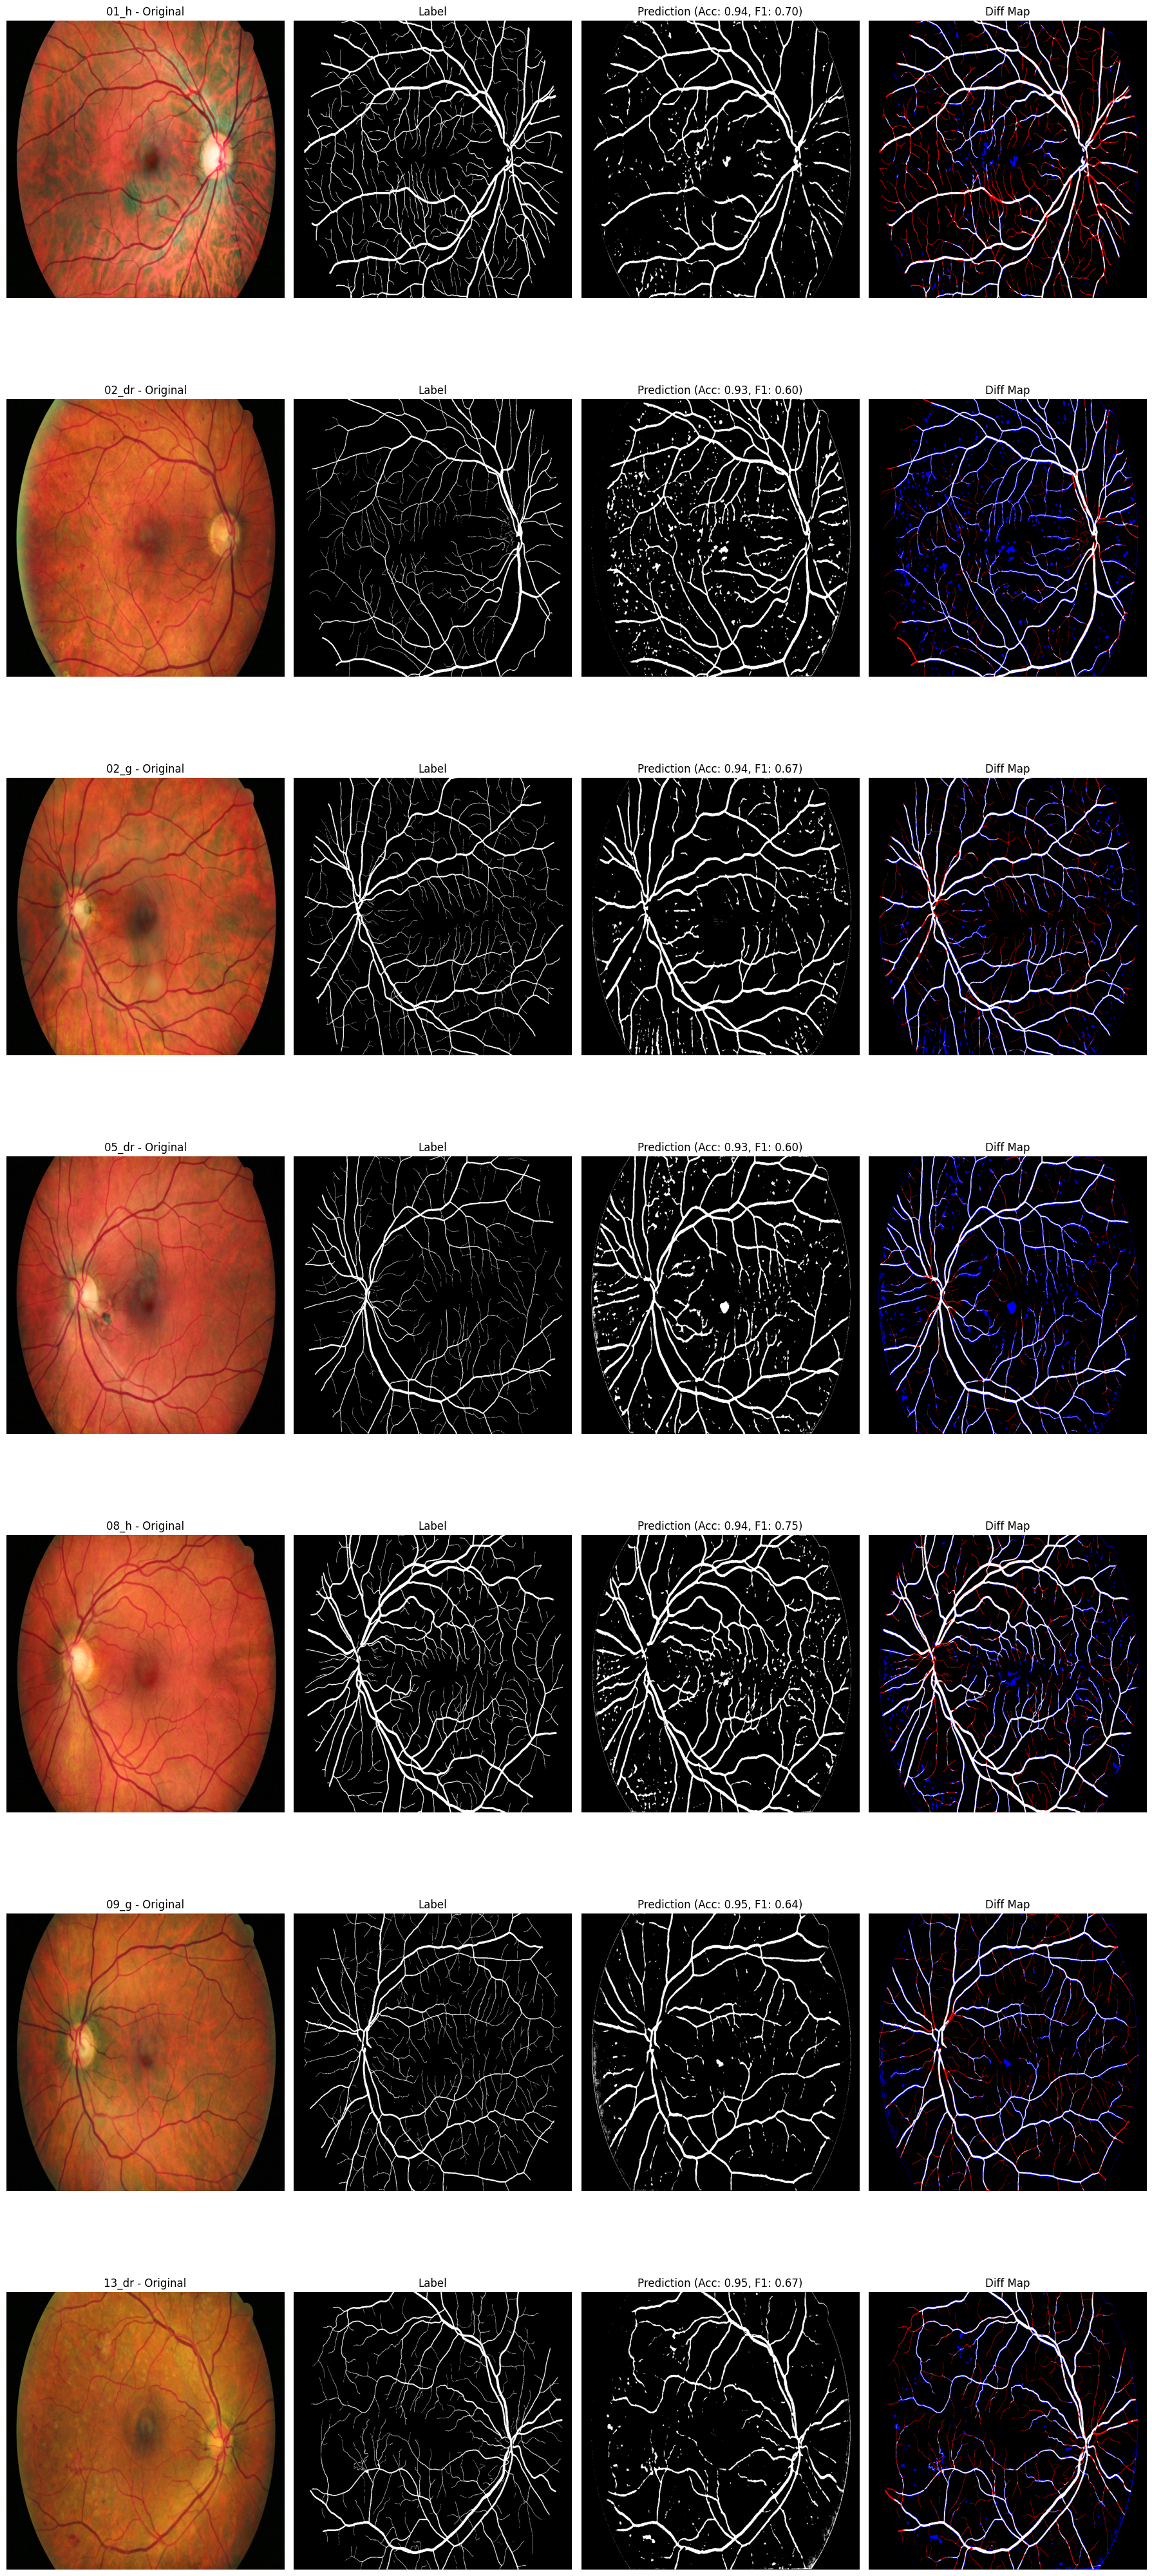

In [2]:
import sys
import os

sys.path.append(os.path.join(os.getcwd(), '..'))
from Data.DatasetSupplier import DatasetSupplier
from Util.Visualisation import Visualisation
import cv2
import numpy as np
import torch
import yaml
import matplotlib.pyplot as plt

from Core.inference import VesselSegmentationInference
from Core.dataset import VesselSegmentationDataset
from torch.utils.data import DataLoader
from Util.config import Config

config = Config.load('config_unet.yaml')

dataset = DatasetSupplier.get_dataset('config_unet.yaml')

test_basenames = ['02_g', '09_g', '01_h', '05_dr', '13_dr', '08_h', '02_dr']

test_samples = [item for item in dataset if item[0] in test_basenames]

data_tuples = [(img_path, mask_path, label_path) for (base, img_path, label_path, mask_path) in test_samples]
test_dataset = VesselSegmentationDataset(
    data_tuples,
    image_transform=None,  # Use default transform (to tensor, normalization)
    target_size=tuple(config['resize_shape']),
    global_contrast_normalization=config.get('preprocessing', {}).get('global_contrast_normalization', False)
)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

inference_engine = VesselSegmentationInference(
    model_path='SavedModels/demo_model_sota.pth',
    config_path='config_unet.yaml',
    device=config.get('device', None)
)

fig, axes = plt.subplots(len(test_samples), 4, figsize=(18, 6 * len(test_samples)))
if len(test_samples) == 1:
    axes = [axes]

# To store metrics for all examples
all_metrics = []

for i, batch in enumerate(test_loader):
    img = batch['image'][0]  # [3, H, W]
    label = batch['label'][0][0].cpu().numpy() * 255  # [H, W]
    mask = batch['mask'][0][0].cpu().numpy()
    base_name = batch['base_name'][0]

    # Run inference using Core inference (single image)
    img_np = img.permute(1, 2, 0).cpu().numpy()  # [H, W, 3]
    img_np_uint8 = (img_np * 255).astype(np.uint8)
    pred_bin, pred_prob = inference_engine.predict_single(
        image=img_np_uint8,
        mask=None,
        threshold=config['inference']['threshold'],
        return_probability=True
    )
    # Mask the predictions: set predictions outside mask to 0
    pred_bin_masked = np.where(mask > 0.5, pred_bin, 0).astype(np.uint8)
    pred_map = pred_bin_masked * 255
    diff_map = np.abs(label.astype(np.float32) - pred_map.astype(np.float32))

    # Calculate metrics for this sample
    label_bin = (label > 0).astype(np.uint8)
    pred_bin_final = (pred_map > 0).astype(np.uint8)
    
    # Calculate true positives, false positives, false negatives
    tp = np.sum((pred_bin_final == 1) & (label_bin == 1))
    fp = np.sum((pred_bin_final == 1) & (label_bin == 0))
    fn = np.sum((pred_bin_final == 0) & (label_bin == 1))
    tn = np.sum((pred_bin_final == 0) & (label_bin == 0))
    
    # Calculate metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    # Store metrics for this sample
    sample_metrics = {
        'base_name': base_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
    all_metrics.append(sample_metrics)
    
    # Print metrics for this sample
    print(f"Sample: {base_name}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")

    Visualisation.plot_comparison_row(
        img_np, label, pred_map, axes_row=axes[i],
        original_title=f"{base_name} - Original",
        label_title="Label",
        prediction_title=f"Prediction (Acc: {accuracy:.2f}, F1: {f1:.2f})",
        diff_map_title="Diff Map"
    )

# Calculate and print average metrics
if all_metrics:
    avg_accuracy = sum(m['accuracy'] for m in all_metrics) / len(all_metrics)
    avg_precision = sum(m['precision'] for m in all_metrics) / len(all_metrics)
    avg_recall = sum(m['recall'] for m in all_metrics) / len(all_metrics)
    avg_f1 = sum(m['f1_score'] for m in all_metrics) / len(all_metrics)
    
    print("\nAverage Metrics Across All Samples:")
    print(f"  Accuracy: {avg_accuracy:.4f}")
    print(f"  Precision: {avg_precision:.4f}")
    print(f"  Recall: {avg_recall:.4f}")
    print(f"  F1 Score: {avg_f1:.4f}")

plt.tight_layout()
plt.show()

[VesselSegmentationDataset] Initialized with 7 samples
[VesselSegmentationDataset] Target size: (256, 256)
[VesselSegmentationDataset] GCN enabled: True
[VesselSegmentationInference] Initialized
  Device: cuda
  Model loaded from: SavedModels/unet_best_1.pth
  Target size: (256, 256)
  Global contrast normalization: True


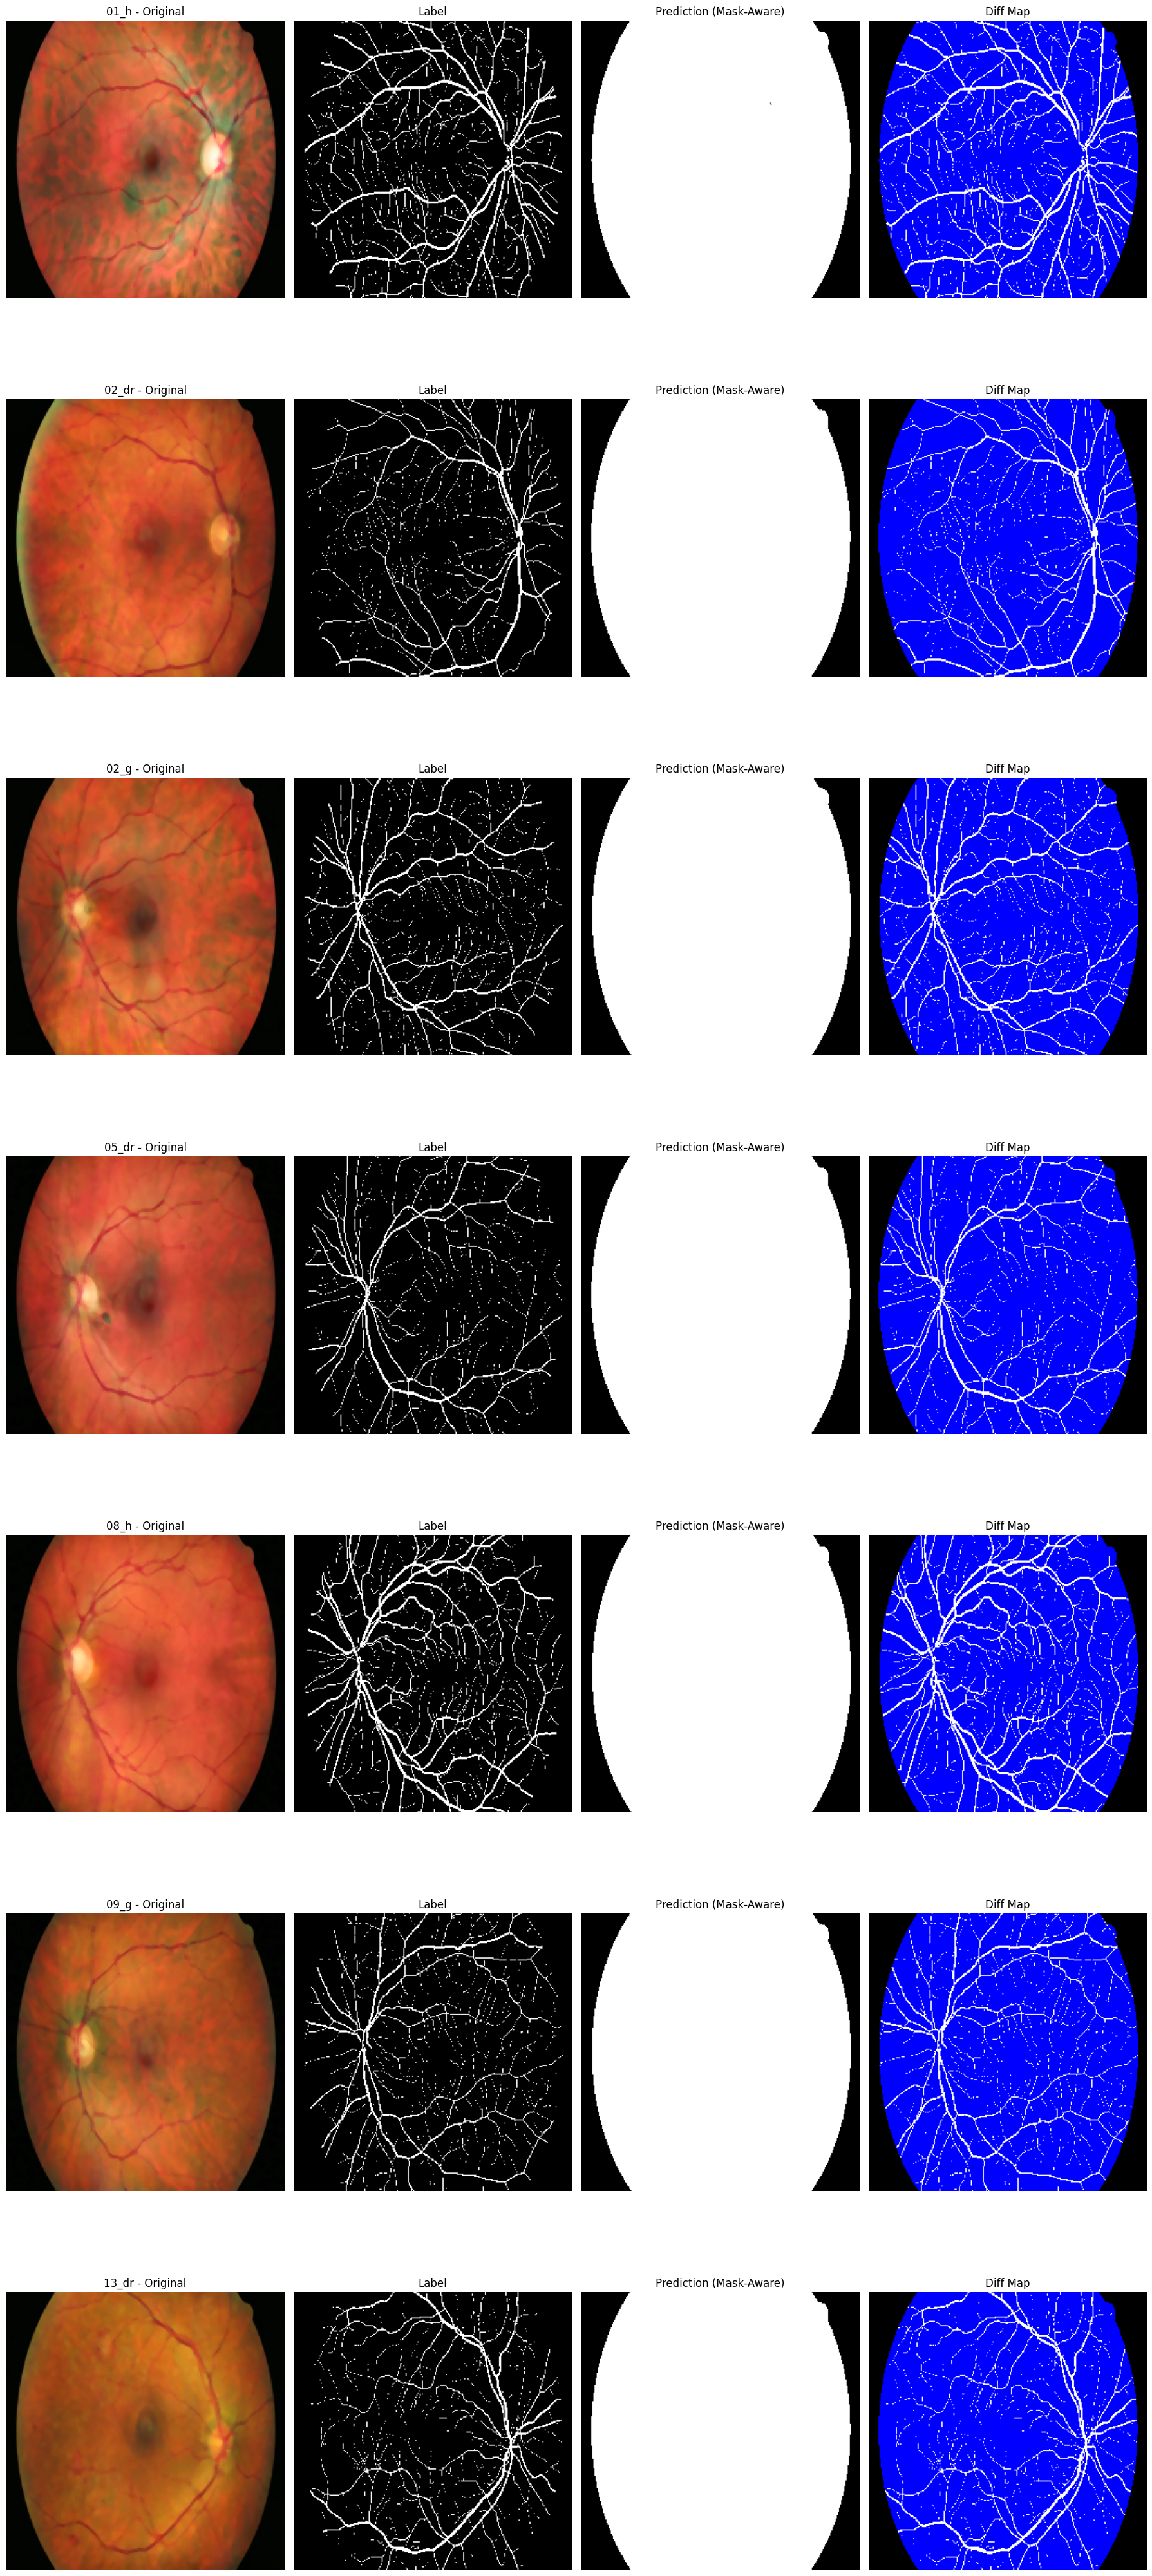

In [ ]:
from Core.inference import VesselSegmentationInference
from Core.dataset import VesselSegmentationDataset
from torch.utils.data import DataLoader
from Data.DatasetSupplier import DatasetSupplier
from Util.Visualisation import Visualisation
import matplotlib.pyplot as plt
import numpy as np

dataset = DatasetSupplier.get_dataset('config_unet.yaml')

test_basenames = ['02_g', '09_g', '01_h', '05_dr', '13_dr', '08_h', '02_dr']

test_samples = [item for item in dataset if item[0] in test_basenames]

data_tuples = [(img_path, mask_path, label_path) for (base, img_path, label_path, mask_path) in test_samples]

# Prepare test dataset and dataloader using Core methods
test_dataset_core = VesselSegmentationDataset(
    data_tuples,
    image_transform=None,
    target_size=tuple(config['resize_shape']),
    global_contrast_normalization=config.get('preprocessing', {}).get('global_contrast_normalization', False)
)
test_loader_core = DataLoader(test_dataset_core, batch_size=1, shuffle=False)

inference_core = VesselSegmentationInference(
    model_path='SavedModels/unet_best_2.pth',
    config_path='config_unet.yaml',
    device=config.get('device', None)
)

# Run inference and visualize results using Core pipeline
fig_core, axes_core = plt.subplots(len(test_samples), 4, figsize=(18, 6 * len(test_samples)))
if len(test_samples) == 1:
    axes_core = [axes_core]

for idx, batch in enumerate(test_loader_core):
    img = batch['image'][0]
    label = batch['label'][0][0].cpu().numpy() * 255
    mask = batch['mask'][0][0].cpu().numpy()
    base_name = batch['base_name'][0]

    img_np = img.permute(1, 2, 0).cpu().numpy()
    img_np_uint8 = (img_np * 255).astype(np.uint8)
    pred_bin, pred_prob = inference_core.predict_single(
        image=img_np_uint8,
        mask=None,
        threshold=config['inference']['threshold'],
        return_probability=True
    )
    pred_bin_masked = np.where(mask > 0.5, pred_bin, 0).astype(np.uint8)
    pred_map = pred_bin_masked * 255
    diff_map = np.abs(label.astype(np.float32) - pred_map.astype(np.float32))

    Visualisation.plot_comparison_row(
        img_np, label, pred_map, axes_row=axes_core[idx],
        original_title=f"{base_name} - Original",
        label_title="Label",
        prediction_title="Prediction (Mask-Aware)",
        diff_map_title="Diff Map"
    )

plt.tight_layout()
plt.show()

In [ ]:
from Core.trainer_clean import VesselSegmentationTrainer
from Util.config import Config

config = Config.load('config_unet.yaml')

# Initialize the trainer with the config file
trainer = VesselSegmentationTrainer(config_path='config_unet.yaml')

# Prepare data splits and loaders
trainer.prepare_data(
    train_split=config['data_split']['train'],
    val_split=config['data_split']['validation'],
    test_split=config['data_split']['test'],
    target_size=tuple(config['resize_shape'])
)

# Initialize the model (parameters are taken from config by default)
trainer.initialize_model(
    in_channels=config['model']['in_channels'],
    num_classes=config['model']['num_classes'],
    base_features=config['model']['base_features']
)

# Train the model
trainer.train(
    num_epochs=config['training']['num_epochs'],
    save_path=config['model_save_path']
)

# Optionally, plot training history
trainer.plot_training_history()

[VesselSegmentationTrainer] Initialized with device: cuda
[VesselSegmentationTrainer] Config loaded from: config_unet.yaml
[VesselSegmentationTrainer] Preparing data...
Found 42 complete data samples
Dataset split: Train=29, Val=6, Test=7
[VesselSegmentationDataset] Initialized with 29 samples
[VesselSegmentationDataset] Target size: (256, 256)
[VesselSegmentationDataset] GCN enabled: True
[VesselSegmentationDataset] Initialized with 6 samples
[VesselSegmentationDataset] Target size: (256, 256)
[VesselSegmentationDataset] GCN enabled: True
[VesselSegmentationDataset] Initialized with 7 samples
[VesselSegmentationDataset] Target size: (256, 256)
[VesselSegmentationDataset] GCN enabled: True
[VesselSegmentationTrainer] Data preparation complete
  Train batches: 8
  Val batches: 2
  Test batches: 2
[VesselSegmentationTrainer] Initializing model...
Using loss type: combined
[VesselSegmentationTrainer] Model initialized
  Total parameters: 7,763,074
  Trainable parameters: 7,763,074
  Learn

f:\source\repos\wykrywanie-naczyn-dna-siatkowki-oka\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/12] (19.2s)
  Train Loss: 0.3052
  Val Loss: 0.2412
  Val IoU: 0.0000
  Val F1: 0.0000
  New best model saved! IoU: 0.9917
Epoch [2/12] (18.2s)
  Train Loss: 0.2031
  Val Loss: 0.2242
  Val IoU: 0.9917
  Val F1: 0.9959
  New best model saved! IoU: 0.9981
Epoch [3/12] (18.0s)
  Train Loss: 0.1610
  Val Loss: 0.2021
  Val IoU: 0.9981
  Val F1: 0.9990
Epoch [4/12] (18.7s)
  Train Loss: 0.1359
  Val Loss: 0.1893
  Val IoU: 0.9932
  Val F1: 0.9966
